In [1]:
# Imports
!pip install opendatasets --upgrade --quiet
import opendatasets as od
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Download the dataset
od.download('https://www.kaggle.com/datasets/mariatherese/australia-weather')
raw_df=pd.read_csv('./australia-weather'+'/australia weather.csv')
raw_df.dropna(subset = ['RainToday', 'RainTomorrow'], inplace = True)
raw_df['RainTomorrow']=raw_df.RainTomorrow.map({'No':0,'Yes':1})

Skipping, found downloaded files in "./australia-weather" (use force=True to force download)


In [2]:
# Create Training, Validation and Test sets
year = pd.to_datetime(raw_df.Date, dayfirst = True, format = 'mixed').dt.year
train_df, val_df, test_df = raw_df [year<2015], raw_df[year == 2015], raw_df[year>2015]
##train_val_df, test_df = train_test_split(raw_df, test_size  = 0.2, random_state = 42)
##train_df, val_df = train_test_split(train_val_df, test_size = 0.25, random_state = 42)

In [3]:
# Identify Inputs and targets
input_cols = list(raw_df.columns)[1:-1]
target_col = 'RainTomorrow'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()
test_inputs, test_targets = test_df[input_cols].copy(), test_df[target_col].copy()

# Identify numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include = np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Impute missing values
imputer = SimpleImputer(strategy = 'mean').fit(raw_df[numeric_cols])
train_inputs[numeric_cols]=imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols]=imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols]=imputer.transform(test_inputs[numeric_cols])

# Scale numeric values
scaler = MinMaxScaler().fit(raw_df[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols]).copy()
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

# One-Hot encode categorical values
encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore').fit(raw_df[categorical_cols])
encoded_cols =list(encoder.get_feature_names_out(categorical_cols))
##train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
##val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
##test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

train_inputs = pd.concat([train_inputs[numeric_cols], pd.DataFrame(encoder.transform(train_inputs[categorical_cols]),columns =encoded_cols,index=train_inputs.index)], axis =1)
val_inputs = pd.concat([val_inputs[numeric_cols], pd.DataFrame(encoder.transform(val_inputs [categorical_cols]),columns =encoded_cols,index=val_inputs.index)], axis =1)
test_inputs = pd.concat([test_inputs[numeric_cols], pd.DataFrame(encoder.transform(test_inputs[categorical_cols]),columns =encoded_cols, index=test_inputs.index)], axis =1)

# Save the data
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')
test_inputs.to_parquet('test_inputs.parquet')
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')
pd.DataFrame(test_targets).to_parquet('test_targets.parquet')

#Load the data back
train_inputs=pd.read_parquet('train_inputs.parquet')
val_inputs=pd.read_parquet('val_inputs.parquet')
test_inputs=pd.read_parquet('test_inputs.parquet')
train_targets=pd.read_parquet('train_targets.parquet')[target_col]
val_targets=pd.read_parquet('val_targets.parquet')[target_col]
test_targets=pd.read_parquet('test_targets.parquet')[target_col]





Accuracy: 89.35%


(array([0, 0, 0, ..., 0, 0, 0]), 0.8934869575866433)

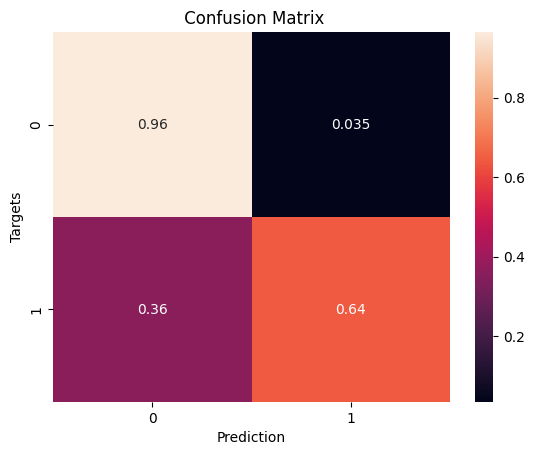

In [29]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
import joblib


# Identify inputs and targets for predictions
##x_train = train_inputs[numeric_cols+encoded_cols]
##x_val = val_inputs[numeric_cols+encoded_cols]
##x__test = test_inputs[numeric_cols+encoded_cols]

# Fit the model
model = XGBClassifier()
model.fit(train_inputs, train_targets)

##Make predictions
preds = model.predict(train_inputs)
prob = model.predict_proba(train_inputs)

# Evaluate the model
accuracy = accuracy_score(train_targets, preds)

# Helper function
def predict_and_plot(inputs, targets, name = ''):
  preds = model.predict(inputs)
  accuracy = accuracy_score(targets, preds)
  print('Accuracy: {:.2f}%'.format(accuracy*100))
  cf=confusion_matrix(targets, preds, normalize='true')
  plt.figure()
  sns.heatmap(cf, annot=True)
  plt.xlabel('Prediction')
  plt.ylabel('Targets')
  plt.title('{} Confusion Matrix'.format(name))
  return preds, accuracy

predict_and_plot(train_inputs,train_targets)



In [32]:
# Make predictions on a single input
def predict_input(single_input):
  input_df =pd.DataFrame([single_input])
  input_df[numeric_cols]=imputer.transform(input_df[numeric_cols])
  input_df[numeric_cols]=scaler.transform(input_df[numeric_cols])
  #input_df[encoded_cols]=scaler.transform(input_df[categorical_cols])
  input_df = pd.concat([input_df[numeric_cols], pd.DataFrame(encoder.transform(input_df[categorical_cols]),columns =encoded_cols,index=input_df.index)], axis =1)
  #x_input=input_df[numeric_cols+encoded_cols]
  pred =model.predict(input_df)[0]
  return pred

new_input = {'Date': '2021-06-19',
             'Location': 'Albury',
             'MinTemp':-0.7,
             'MaxTemp':50.2,
             'Rainfall':10.2,
             'Evaporation':4.2,
             'Sunshine':np.nan,
             'WindGustDir':'NNW',
             'WindGustSpeed':52.0,
             'WindDir9am':'NW',
             'WindDir3pm':'NNE',
             'WindSpeed9am':13.0,
             'WindSpeed3pm':20.0,
             'Humidity9am':89.0,
             'Humidity3pm':58.0,
             'Pressure9am':1004.8,
             'Pressure3pm':1001.5,
             'Cloud9am':8.0,
             'Cloud3pm':5.0,
             'Temp9am':25.7,
             'Temp3am':33.0,
             'RainToday':'No' }

predict_input(new_input)


# Save the model to joblib and load
aussie_rain= {'model':model, 'imputer':imputer, 'scaler': scaler, 'encoder':encoder,
              'input_cols':input_cols, 'target_col':target_col, 'numeric_cols':numeric_cols,
              'categorical_cols':categorical_cols, 'encoded_cols':encoded_cols}
joblib.dump(aussie_rain,'aussie_rain.joblib')
aussie_rain2 = joblib.load('aussie_rain.joblib')

In [ ]:
# In a new notebook
aussie_rain2 =joblib.load('aussie_rain(1).joblib')

model= aussie_rain2['model']
imputer= aussie_rain2['imputer']
scaler= aussie_rain2['scaler']
encoder= aussie_rain2['encoder']
numeric_cols= aussie_rain2['numeric_cols']
categorical_cols= aussie_rain2['categorical_cols']
encoded_cols= aussie_rain2['encoded_cols']